In [1]:
from StepperController import StepperController
import cv2 as cv
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

### PLACE THE SAUSAGE IN INITIAL POSITION
**Flat part of the ring to the top**

In [4]:
DATA_PATH = "../data"
ROTATION_COUNT = 15
DEGREE_PER_IMAGE = 1
IMAGE_SIZE = 640
SAUSAGE_RATIO = 58/12
YOLO_CONFIDENCE = 0.4

In [5]:
controller = StepperController('/dev/tty.usbserial-2130')
yolo_model = YOLO('../weights/yolo11n_trained_new.pt')
cap_top = cv.VideoCapture(1)
cap_side = cv.VideoCapture(0)

Connected to Arduino on /dev/tty.usbserial-2130


In [6]:
def process_frame(frame, yolo_model):
    w, h = frame.shape[1], frame.shape[0]
    image = frame[h//2 - IMAGE_SIZE//2:h//2 + IMAGE_SIZE//2, w//2 - IMAGE_SIZE//2:w//2 + IMAGE_SIZE//2]
    results = yolo_model(image, verbose=False)
    detections = results[0]  # Extract detections

    if len(detections) == 0:
        return None
    
    det = detections[0]

    max_conf = 0
    for i in range(len(det.boxes)):
        conf = det.boxes.conf[i].item()
        if conf > max_conf:
            max_conf = conf
            det = detections[i]

    if max_conf < YOLO_CONFIDENCE:  # Confidence threshold
        return None
    
    x1, y1, x2, y2 = det.boxes.xyxy[0].tolist()
    conf = det.boxes.conf[0].item()
    
    # Crop the detected region
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    padding = 0.1
    x1 = x1 - int((x2 - x1) * padding)
    y1 = y1 - int((y2 - y1) * padding)
    x2 = x2 + int((x2 - x1) * padding)
    y2 = y2 + int((y2 - y1) * padding)

    cropped = image[y1:y2, x1:x2]

    return cropped

### Test frame reading to set up bounding boxes

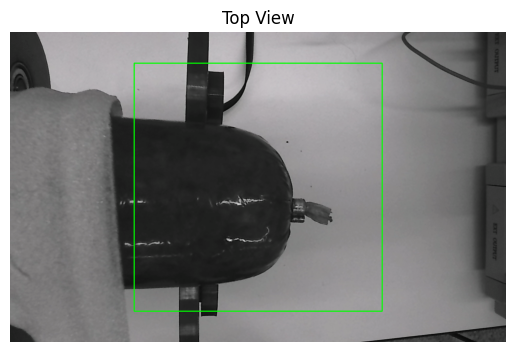

Frame shape: (800, 1280, 3)


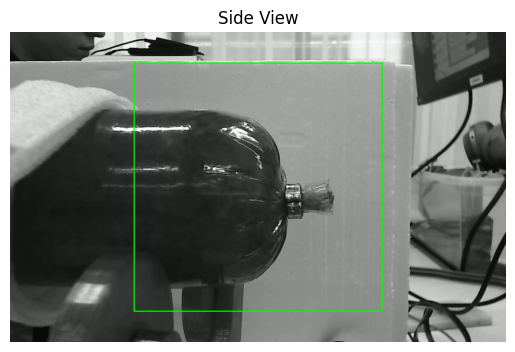

In [7]:
ret, frame = cap_top.read()
if not ret:
    print("Error: Could not read frame from webcam.")
w, h = frame.shape[1], frame.shape[0]
image = cv.rectangle(frame, (w//2 - IMAGE_SIZE//2, h//2 - IMAGE_SIZE//2), (w//2 + IMAGE_SIZE//2, h//2 + IMAGE_SIZE//2), (0, 255, 0), 2)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title("Top View")
plt.axis('off')
plt.show()

ret, frame = cap_side.read()
if not ret:
    print("Error: Could not read frame from webcam.")
w, h = frame.shape[1], frame.shape[0]
print(f"Frame shape: {frame.shape}")
image = cv.rectangle(frame, (w//2 - IMAGE_SIZE//2, h//2 - IMAGE_SIZE//2), (w//2 + IMAGE_SIZE//2, h//2 + IMAGE_SIZE//2), (0, 255, 0), 2)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.title("Side View")
plt.axis('off')
plt.show()

### Test ring detection

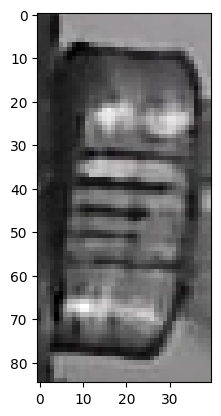

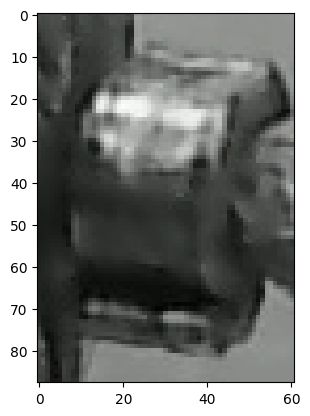

In [6]:
ret, frame = cap_top.read()
if not ret:
    print("Error: Could not read frame from top webcam.")
image = process_frame(frame, yolo_model)
if image is None:
    print("No detection found from top.")
else:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

ret, frame = cap_side.read()
if not ret:
    print("Error: Could not read frame from side webcam.")
image = process_frame(frame, yolo_model)
if image is None:
    print("No detection found from side.")
else:
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

In [7]:
os.makedirs(DATA_PATH, exist_ok=True)
pbar = tqdm(total=ROTATION_COUNT * (360 // DEGREE_PER_IMAGE), desc="Total Progress")
save_path_top = os.path.join(DATA_PATH, "raw_data/top")
save_path_side = os.path.join(DATA_PATH, "raw_data/side")
os.makedirs(save_path_top, exist_ok=True)
os.makedirs(save_path_side, exist_ok=True)
for rot in tqdm(range(ROTATION_COUNT), desc="Loop"):
    for d in tqdm(range(0, 360, DEGREE_PER_IMAGE), desc="Degrees", leave=False):
        pbar.update(1)
        degrees = (360*rot + d) * SAUSAGE_RATIO
        controller.rotate_to_angle(degrees, verbose=False)

        ret, frame = cap_top.read()
        image = process_frame(frame, yolo_model)
        if image is None:
            print("No detection found for TOP camera.")
            continue
        cv.imwrite(os.path.join(save_path_top, f"image_top_{rot}_{d}.jpg"), image)

        ret, frame = cap_side.read()
        image = process_frame(frame, yolo_model)
        if image is None:
            print("No detection found for SIDE camera.")
            continue
        cv.imwrite(os.path.join(save_path_side, f"image_side_{rot}_{d}.jpg"), image)

pbar.close()

Total Progress:   0%|          | 0/5400 [00:00<?, ?it/s]

Loop:   0%|          | 0/15 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for SIDE camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for SIDE camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for SIDE camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for SIDE camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for SIDE camera.
No detection found for SIDE camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


Degrees:   0%|          | 0/360 [00:00<?, ?it/s]

No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.
No detection found for TOP camera.


In [8]:
# path = os.path.join(DATA_PATH, "by_degrees")
# classes = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]

# # Count the number of images in each class
# class_counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in classes}

# # Plot the histogram
# plt.scatter(class_counts.keys(), class_counts.values())
# plt.xlabel('Class')
# plt.ylabel('Number of Images')
# plt.title('Distribution of Images by Class')
# plt.xticks(rotation=90)
# plt.show()